In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas
import torch
import os
from tqdm import tqdm
np.random.seed(42)



In [2]:


bus_df = pandas.read_csv(r"..\data\01_test_cases\case6ww\raw\bus_data.txt",sep = '\t')

pd_list = bus_df["Pd"].tolist()
print(pd_list)

pd_re_list = pd_list + [0] * len(pd_list)
print(pd_re_list)


[0, 0, 0, 70, 70, 70]
[0, 0, 0, 70, 70, 70, 0, 0, 0, 0, 0, 0]


In [3]:
def generate_mu_sigma(P_d, T):
    """
    生成一条长度为 T 的 mu 和 sigma，符合给定扰动规则。
    参数:
    - P_d: 节点负荷基准值
    - T: 时长（通常为24）
    """
    mu = np.zeros(T)
    sigma = np.zeros(T)

    # 初始值
    mu[0] = np.random.uniform(0.5 * P_d, 1.5 * P_d)
    CV = np.random.uniform(0.05, 0.3)
    sigma[0] = CV * mu[0]

    for t in range(1, T):
        lower_delta = max(-0.2 * P_d, 0.5 * P_d - mu[t-1])
        upper_delta = min(0.2 * P_d, 1.5 * P_d - mu[t-1])
        delta = np.random.uniform(lower_delta, upper_delta)

        mu[t] = mu[t-1] + delta
        CV = np.random.uniform(0.05, 0.3)
        sigma[t] = CV * mu[t]

    return mu, sigma


from scipy.stats import truncnorm

def generate_TN_distributions(mu, sigma):
    """
    返回每个时刻 t 的截断正态分布对象，用于采样
    参数:
    - mu: list or array of length T
    - sigma: list or array of length T
    返回:
    - tn_dists: list of truncnorm distribution objects, each can be sampled later
    """
    tn_dists = []
    for m, s in zip(mu, sigma):
        a, b = -2, 2  # 截断范围为 ±2σ（标准正态化）
        dist = truncnorm(a=a, b=b, loc=m, scale=s)
        tn_dists.append(dist)

    return tn_dists


C:\Users\HK\AppData\Local\Temp\ipykernel_6076\3621542053.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet', num_samples)


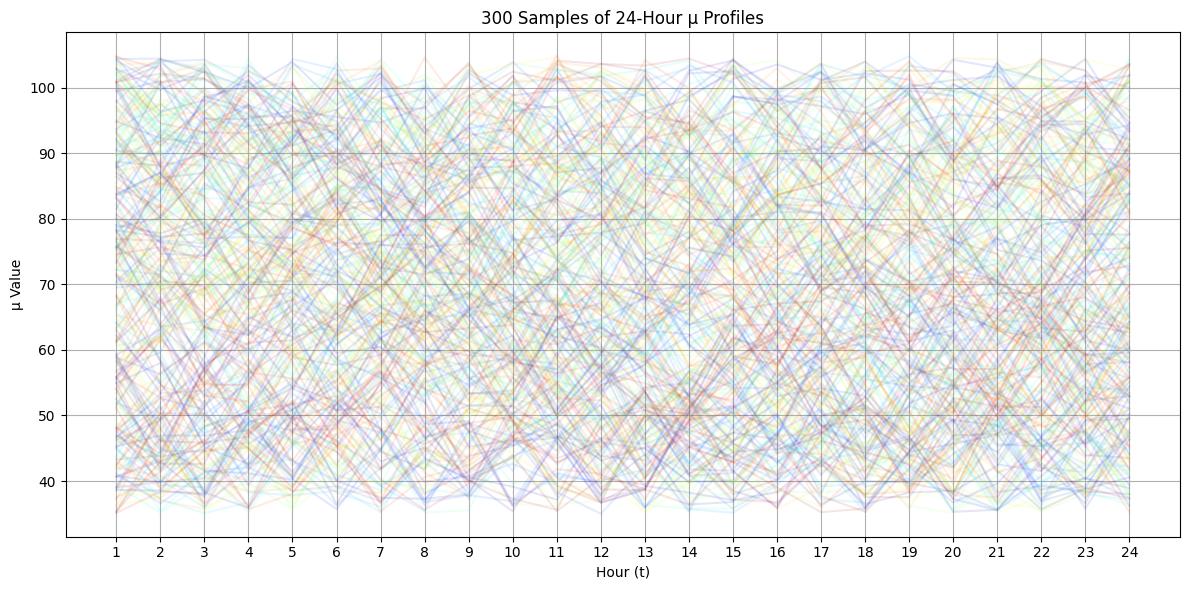

In [4]:
num_samples = 300
T = 24
P_d = 70

plt.figure(figsize=(12, 6))
cmap = plt.cm.get_cmap('jet', num_samples)
for i in range(num_samples):
    mu, _ = generate_mu_sigma(P_d, T)
    plt.plot(range(1, T+1), mu, color=cmap(i), alpha=0.1)  # 透明度设置为0.1

plt.xlabel('Hour (t)')
plt.ylabel('μ Value')
plt.title(f'{num_samples} Samples of 24-Hour μ Profiles')
plt.xticks(range(1, T+1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:




def generate_df(
        storage_path,
        n_samples,
        n_stages = 24,
        n_bus = 6,
        n_realizations = 6
        ):

    mu_plot_list = []
    for index in tqdm(range(1, n_samples + 1), desc="Generating df"):

        parameter_columns = "t	Pd1	Pd2	Pd3	Pd4	Pd5	Pd6	Pd1_sigma	Pd2_sigma	Pd3_sigma	Pd4_sigma	Pd5_sigma	Pd6_sigma".split("\t")
        # print(parameter_columns)
        scenario_columns = "t	n	p	Pd1	Pd2	Pd3	Pd4	Pd5	Pd6	Re1	Re3	Re4	Re5	Re6	Re2".split("\t")
        # print(scenario_columns)
        parameter_df = pandas.DataFrame(columns=parameter_columns)
        scenario_df = pandas.DataFrame(columns=scenario_columns)
        mu_bus_list = []
        sigma_bus_list = []
        dist_bus_list = []
        for pd in pd_list:
            if pd != 0:
                mu, sigma = generate_mu_sigma(pd, n_stages)
                mu_plot_list.append(mu)
                tn_dists = generate_TN_distributions(mu, sigma)
                dist_bus_list.append(tn_dists)
            else:
                mu = np.zeros(n_stages)
                sigma = np.zeros(n_stages)
                dist_bus_list.append(None)
            mu_bus_list.append(mu)
            sigma_bus_list.append(sigma)


        for t in range(n_stages):
            row = {"t": t + 1}
            # 添加 Pd1~Pd6
            for i in range(n_bus):
                row[f"Pd{i+1}"] = mu_bus_list[i][t]
            # 添加 Pd1_sigma~Pd6_sigma
            for i in range(n_bus):
                row[f"Pd{i+1}_sigma"] = sigma_bus_list[i][t]
            # 添加到 DataFrame
            parameter_df.loc[len(parameter_df)] = row
        # print(parameter_df)


        for t in range(n_stages):
            if t == 0:
                row = {"t": t + 1}
                row["n"] = 1
                row["p"] = 1
                for i in range(n_bus):
                    row[f"Pd{i+1}"] = mu_bus_list[i][t]
                for i in range(n_bus):
                    row[f"Re{i+1}"] = 0
                scenario_df.loc[len(scenario_df)] = row
            else:
                for n in range(n_realizations):
                    row = {"t": t + 1}
                    row["n"] = n + 1
                    row["p"] = 1 / n_realizations
                    for i in range(n_bus):
                        if dist_bus_list[i] is not None:
                            row[f"Pd{i+1}"] = dist_bus_list[i][t].rvs()
                        else:
                            row[f"Pd{i+1}"] = 0
                    for i in range(n_bus):
                        row[f"Re{i+1}"] = 0
                    scenario_df.loc[len(scenario_df)] = row
        # print(scenario_df)

        if (scenario_df < 0).any().any():
            raise Exception(f"存在小于 0 的值 {index}_scenario.csv")
        if (parameter_df < 0).any().any():
            raise Exception(f"存在小于 0 的值 {index}_parameter.csv")
        if os.path.exists(os.path.join(storage_path, f"{index}_scenario.csv")):
            raise Exception(f"文件 {os.path.join(storage_path, f'{index}_scenario.csv')} 已存在，保存失败。")
        if os.path.exists(os.path.join(storage_path, f"{index}_parameter.csv")):
            raise Exception(f"文件 {os.path.join(storage_path, f'{index}_parameter.csv')} 已存在，保存失败。")
        parameter_df.to_csv(os.path.join(storage_path, f"{index}_parameter.csv"), sep="\t", index=False)
        scenario_df.to_csv(os.path.join(storage_path, f"{index}_scenario.csv"), sep="\t", index=False)


    plt.figure(figsize=(12, 6))
    cmap = plt.cm.get_cmap('jet', len(mu_plot_list))
    for i in range(len(mu_plot_list)):
        m = mu_plot_list[i]
        plt.plot(range(1, n_stages+1), m, color=cmap(i), alpha=0.1)
    plt.xlabel('Hour (t)')
    plt.ylabel('μ Value')
    plt.title(f'{num_samples} Samples of 24-Hour μ Profiles')
    plt.xticks(range(1, T+1))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(storage_path, f"scenario_mu.png"))
    plt.show()




D:\tools\workspace_pycharm\sddip-SCUC-6-24\train_data_temp_pkg


Generating df: 100%|███████████████████████████████████████████████████████████████| 1000/1000 [08:40<00:00,  1.92it/s]
C:\Users\HK\AppData\Local\Temp\ipykernel_6076\3973783959.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet', len(mu_plot_list))


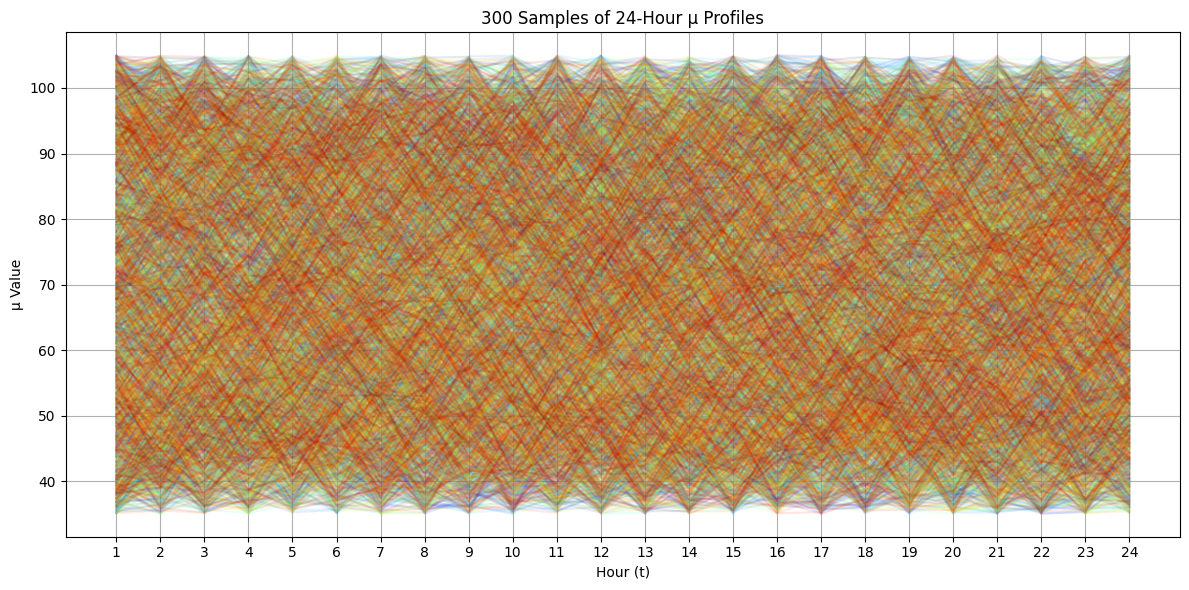

In [7]:
train_data_path = r"D:\tools\workspace_pycharm\sddip-SCUC-6-24\ifr_data"
print(train_data_path)
np.random.seed(42)
generate_df(os.path.join(train_data_path, "scenarios"), 1000)

In [ ]:

'''
sigma 从min~max中采样
'''
from path_config import train_data_path
import os

# 表头
header_str = "t	n	p	Pd1	Pd2	Pd3	Pd4	Pd5	Pd6	Re1	Re3	Re4	Re5	Re6	Re2"
header_str1 = "t	n	p	Pd1	Pd2	Pd3	Pd4	Pd5	Pd6	Re1	Re3	Re4	Re5	Re6	Re2 Pd1_sigma	Pd2_sigma	Pd3_sigma	Pd4_sigma	Pd5_sigma	Pd6_sigma	Re1_sigma	Re3_sigma	Re4_sigma	Re5_sigma	Re6_sigma	Re2_sigma"
columns_name_scenario = header_str.replace("\t", " ").split()
columns_name_parameter = header_str1.replace("\t", " ").split()
# print(columns_name)
# print(len(columns_name))


num_data = 10000
n_stage = 24
problem_n_realizations = 6
storage_path = os.path.join(train_data_path, "scenarios")
print(storage_path)


for i in range(0, num_data):
    scenario_list = []
    parameter_list = []
    for t in range(1, n_stage + 1):
        index_parameter = [t]
        mu = np.random.uniform(low=mean_min, high=mean_max)
        # sigma = std
        sigma = np.random.uniform(low=std_min, high=std_max)
        param = np.concatenate((index_parameter, mu, sigma))
        parameter_list.append(param)
        if t == 1:
            n_realizations = 1
        else:
            n_realizations = problem_n_realizations
        p = 1/n_realizations
        for n in range(1, n_realizations + 1):
            index = [t, n, p]
            # pds = np.random.normal(mu, sigma)
            # 避免出现负数
            # pds = np.array([
            #     m if s == 0 else truncnorm(a=(0 - m) / s, b=np.inf, loc=m, scale=s).rvs()
            #     for m, s in zip(mu, sigma)
            # ])
            pds = np.random.normal(mu, sigma)
            pds = np.maximum(pds, 0)  # 所有负数截断为 0
            sce = np.concatenate((index, pds))
            scenario_list.append(sce)

    scenario_df = pd.DataFrame(np.array(scenario_list), columns=columns_name_scenario)
    # parameter: t + mu + sigma
    parameter_df = pd.DataFrame(parameter_list, columns=columns_name_parameter[0:1] + columns_name_parameter[3:])

    if (scenario_df < 0).any().any():
        print(f"存在小于 0 的值 {i+1}_scenario.csv")
    if (parameter_df < 0).any().any():
        print(f"存在小于 0 的值 {i+1}_parameter.csv")

    scenario_file_path = storage_path / f"{i+1}_scenario.csv"
    if not scenario_file_path.exists():
        scenario_df.to_csv(scenario_file_path, sep='\t', index=False)
    else:
        print(f"文件 {scenario_file_path} 已存在，保存失败。")

    parameter_file_path = storage_path / f"{i+1}_parameter.csv"
    if not parameter_file_path.exists():
        parameter_df.to_csv((parameter_file_path),sep='\t',index=False)
    else:
        print(f"文件 {parameter_file_path} 已存在，保存失败。")



